In [102]:
import pandas as pd
import os
import json
from tqdm import tqdm
import networkx as nx
import semanticscholar as sch
import urllib
import json
import requests
import jsonlines
import statistics
from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.cluster import MiniBatchKMeans

In [103]:
def compute_rating(ratings):
    individual_ratings = [int(item.split(":")[0]) for item in ratings]
    score = round(statistics.mean(individual_ratings))
    return categorize(score)

def categorize(score):
    if score < 4:
        return 'weak'
    if score in (4,5):
        return 'avg'
    if score in (6,7):
        return 'good'
    else: return 'strong'

In [108]:
cur_path = os.getcwd()
review_path = os.path.relpath('..//data//paper_quality//', cur_path)

review_list = []
with jsonlines.open(review_path+'\\'+'iclr2018_metadata.jsonl') as f:
    review_list = [line for line in f.iter() if len(line['review_ratings'])>0]
review_df = pd.DataFrame(review_list)
review_df['rating'] = review_df['review_ratings'].apply(lambda x : compute_rating(x))
review_df['title'] = review_df['submission_content'].apply(lambda x : x['title'])
review_df.to_pickle("..\\data\\paper_quality\\review_data.pkl")
review_df = pd.read_pickle("..\\data\\paper_quality\\review_data.pkl")
review_df

,forum,review_ratings,decision,submission_content,rating,title
0,Hk6kPgZA-,"[9: Top 15% of accepted papers, strong accept,...",Accept (Oral),{'title': 'Certifying Some Distributional Robu...,strong,Certifying Some Distributional Robustness with...
1,ByED-X-0W,"[4: Ok but not good enough - rejection, 6: Mar...",Reject,{'title': 'Parametric Information Bottleneck t...,avg,Parametric Information Bottleneck to Optimize ...
2,HktJec1RZ,"[6: Marginally above acceptance threshold, 6: ...",Accept (Poster),{'title': 'Towards Neural Phrase-based Machine...,good,Towards Neural Phrase-based Machine Translation
3,S1pWFzbAW,"[6: Marginally above acceptance threshold, 6: ...",Invite to Workshop Track,{'title': 'Weightless: Lossy Weight Encoding F...,avg,Weightless: Lossy Weight Encoding For Deep Neu...
4,H1UOm4gA-,"[7: Good paper, accept, 6: Marginally above ac...",Accept (Poster),{'title': 'Interactive Grounded Language Acqui...,good,Interactive Grounded Language Acquisition and ...
...,...,...,...,...,...,...
905,HJ5AUm-CZ,"[7: Good paper, accept, 5: Marginally below ac...",Reject,{'title': 'The Variational Homoencoder: Learni...,good,The Variational Homoencoder: Learning to Infer...
906,rJ5C67-C-,"[5: Marginally below acceptance threshold, 5: ...",Reject,{'title': 'Hyperedge2vec: Distributed Represen...,avg,Hyperedge2vec: Distributed Representations for...
907,HkPCrEZ0Z,"[5: Marginally below acceptance threshold, 5: ...",Reject,{'title': 'Combining Model-based and Model-fre...,avg,Combining Model-based and Model-free RL via Mu...
908,Syt0r4bRZ,"[2: Strong rejection, 5: Marginally below acce...",Reject,{'title': 'Tree2Tree Learning with Memory Unit...,avg,Tree2Tree Learning with Memory Unit


In [85]:
'''            
with jsonlines.open(review_path+'\\'+'iclr2018_metadata.jsonl') as f:

    for line in f.iter():
        individual_ratings = [int(item.split(":")[0]) for item in line['review_ratings']]
        if len(individual_ratings)>0:
            ratings_list.append(round(statistics.mean(individual_ratings)))
            idea_list.append(line['submission_content']['abstract'])
            tldr_list.append(' '.join(line['submission_content']['keywords']))
            
rating_df = pd.DataFrame()
ratings_list = []
idea_list = []
tldr_list = []


rating_df['keywords'] = tldr_list                        
rating_df['idea'] = idea_list
rating_df['rating'] = ratings_list

rating_df['idea'] = rating_df['idea'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop])).str.lower()
rating_df['idea'] = rating_df['idea'].str.lower()
rating_df['rating'] = rating_df['rating'].apply(lambda x: categorize(x)) 
'''

In [88]:
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2',ngram_range=(2,4), lowercase=True, stop_words='english')
features_abstract = tfidf.fit_transform(rating_df.idea).toarray()
features_keywords = tfidf.fit_transform(rating_df.keywords).toarray()
labels = rating_df.rating

In [81]:
models = [
    RandomForestClassifier(n_estimators=20, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_keywords, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


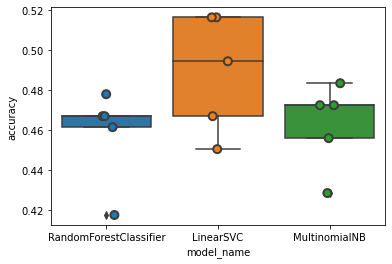

model_name
LinearSVC                 0.489011
MultinomialNB             0.462637
RandomForestClassifier    0.458242
Name: accuracy, dtype: float64

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
cv_df.groupby('model_name').accuracy.mean()

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters


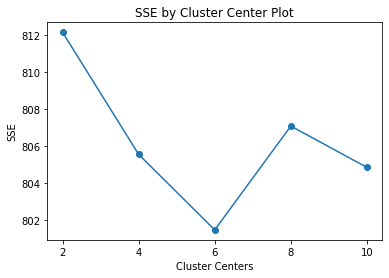

In [89]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(features_keywords,10)

In [90]:
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(features_keywords)



In [95]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.toarray()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(features_keywords, clusters, tfidf.get_feature_names(), 10)

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'